# 08.5c: Black Hole Population Dynamics

**Analyze how black hole populations evolve during training**

This notebook loads pre-computed black hole statistics and examines:
- Total population in black holes over time
- Number of black holes over time
- **Mean tokens per black hole** (the key metric)
- Correlation with fission events

## Key Question

Do black holes grow or shrink during training? Does fission fragment large black holes into smaller ones?

## Parameters

In [13]:
# Data directories
DATA_DIR = "../data"
RUN_PATTERN = "embeddings_128vocab_qweninit_run_*"
COUNTS_FILE = "black_hole_counts.safetensors"

# Expected dimensions
EXPECTED_RUNS = 16
EXPECTED_STEPS = 10001

# Plotting
COLORMAP = 'inferno'
DPI = 100

RANDOM_SEED = 42

## Imports

In [14]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

np.random.seed(RANDOM_SEED)

## Load Pre-computed Statistics

In [15]:
data_dir = Path(DATA_DIR)
run_dirs = sorted(data_dir.glob(RUN_PATTERN))

print(f"Found {len(run_dirs)} runs")

if len(run_dirs) != EXPECTED_RUNS:
    print(f"⚠ WARNING: Expected {EXPECTED_RUNS} runs, found {len(run_dirs)}")

Found 16 runs


In [16]:
# Load all statistics
counts_data = {}  # run_name -> counts array
populations_data = {}  # run_name -> populations array
largest_bh_data = {}  # run_name -> largest_bh_size array

for run_dir in tqdm(run_dirs, desc="Loading runs"):
    run_name = run_dir.name.split('_')[-1]
    counts_path = run_dir / COUNTS_FILE
    
    if not counts_path.exists():
        print(f"⚠ {run_name}: counts file not found, skipping")
        continue
    
    data = load_file(counts_path)
    counts_data[run_name] = data['counts'].numpy()
    populations_data[run_name] = data['populations'].numpy()
    largest_bh_data[run_name] = data['largest_bh_size'].numpy()

print(f"\n✓ Loaded statistics for {len(counts_data)} runs")

Loading runs:   0%|          | 0/16 [00:00<?, ?it/s]


✓ Loaded statistics for 16 runs


## Compute Mean Tokens Per Black Hole

In [17]:
mean_size_data = {}  # run_name -> mean_size array

for run_name in sorted(counts_data.keys()):
    counts = counts_data[run_name]
    populations = populations_data[run_name]
    
    # Handle division by zero (when counts == 0, mean size is undefined)
    mean_size = np.zeros_like(counts, dtype=float)
    mask = counts > 0
    mean_size[mask] = populations[mask] / counts[mask]
    
    mean_size_data[run_name] = mean_size

print(f"✓ Computed mean black hole size for {len(mean_size_data)} runs")

✓ Computed mean black hole size for 16 runs


## Detect Fission Events

Load fission event locations from our previous analysis.

In [18]:
# Detect increases in black hole count (fission events)
fission_events = {}  # run_name -> list of (step, count_before, count_after)

for run_name, counts in sorted(counts_data.items()):
    increases = []
    for step in range(1, len(counts)):
        if counts[step] > counts[step - 1]:
            increases.append((step, counts[step - 1], counts[step]))
    fission_events[run_name] = increases

total_fission_events = sum(len(events) for events in fission_events.values())
print(f"✓ Detected {total_fission_events} fission events across {len(fission_events)} runs")

✓ Detected 95 fission events across 16 runs


## Plot 1: Mean Tokens Per Black Hole (Log Scale)

**The key plot**: How does mean black hole size change with training?

Hypothesis: Early explosive fission fragments large primordial black hole into many small ones.

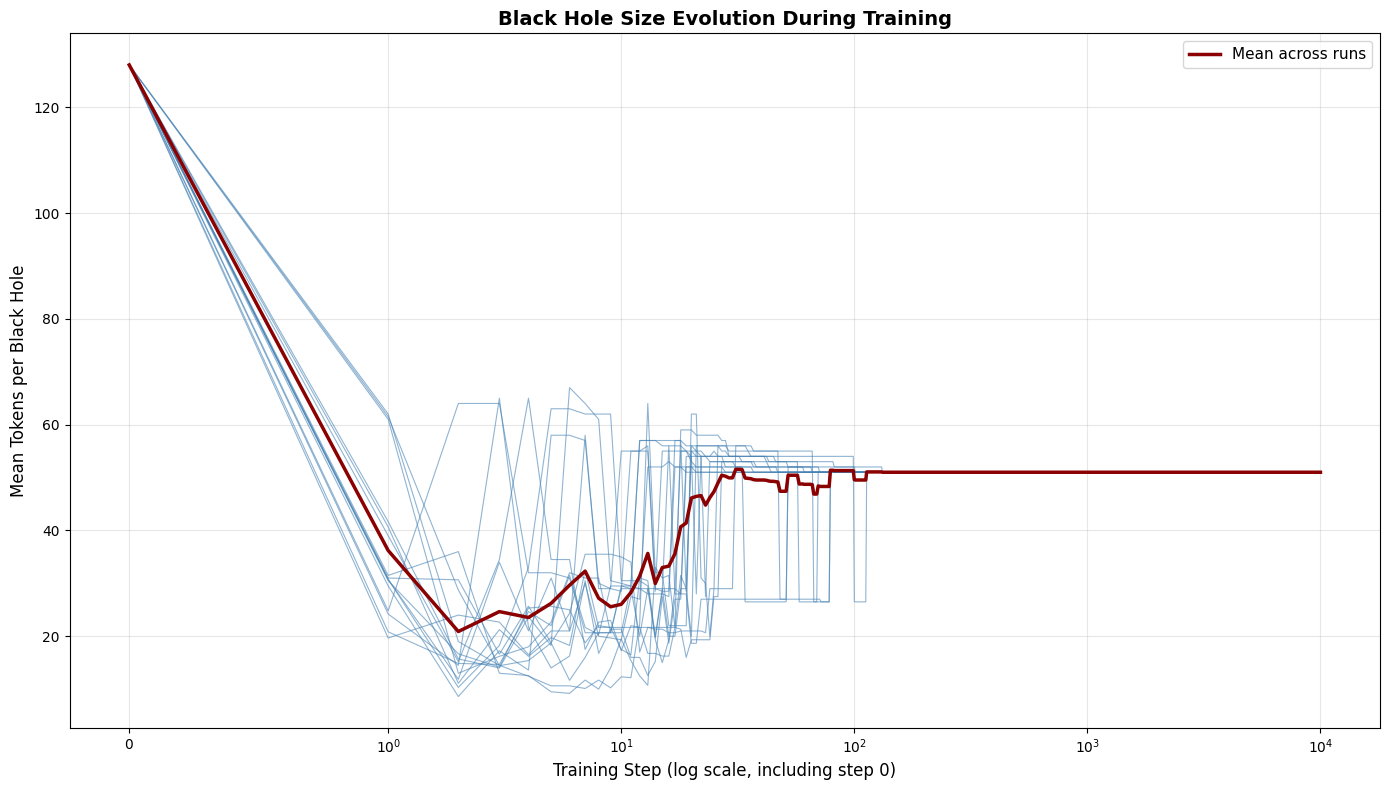


Mean BH size at step 0: 128.00 tokens
Mean BH size at step 1: 36.21 tokens
Mean BH size at step 100: 49.59 tokens
Mean BH size at step 1000: 51.00 tokens
Mean BH size at step 10000: 51.00 tokens


In [19]:
fig, ax = plt.subplots(figsize=(14, 8), dpi=DPI)

# Plot all runs with semi-transparent lines
for run_name in sorted(mean_size_data.keys()):
    mean_size = mean_size_data[run_name]
    
    # Mask out zeros (no black holes exist)
    steps = np.arange(len(mean_size))
    valid_mask = mean_size > 0
    
    ax.plot(steps[valid_mask], mean_size[valid_mask], 
            linewidth=0.8, alpha=0.6, color='steelblue')

# Compute and plot mean trajectory across all runs
all_mean_sizes = np.stack([mean_size_data[run] for run in sorted(mean_size_data.keys())])
mean_trajectory = np.mean(all_mean_sizes, axis=0)
valid_mean_mask = mean_trajectory > 0

ax.plot(steps[valid_mean_mask], mean_trajectory[valid_mean_mask],
        linewidth=2.5, color='darkred', label='Mean across runs', zorder=10)

ax.set_xscale('symlog', linthresh=1)
ax.set_xlabel('Training Step (log scale, including step 0)', fontsize=12)
ax.set_ylabel('Mean Tokens per Black Hole', fontsize=12)
ax.set_title('Black Hole Size Evolution During Training', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"\nMean BH size at step 0: {mean_trajectory[0]:.2f} tokens")
print(f"Mean BH size at step 1: {mean_trajectory[1]:.2f} tokens")
print(f"Mean BH size at step 100: {mean_trajectory[100]:.2f} tokens")
print(f"Mean BH size at step 1000: {mean_trajectory[1000]:.2f} tokens")
print(f"Mean BH size at step 10000: {mean_trajectory[10000]:.2f} tokens")

## Plot 2: Population Evolution

How many tokens total are trapped in black holes?

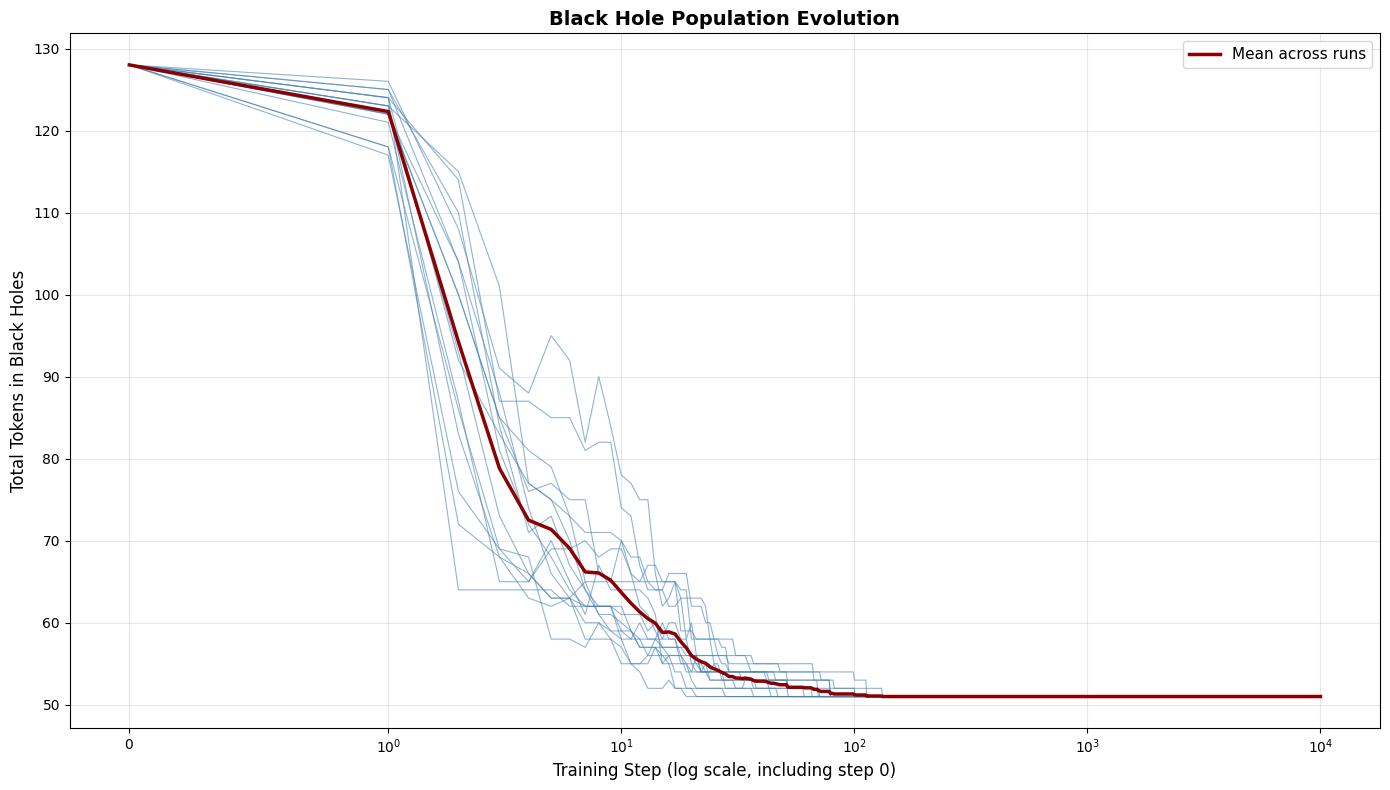


Mean population at step 0: 128.0 tokens
Mean population at step 1: 122.3 tokens
Mean population at step 100: 51.2 tokens
Mean population at step 1000: 51.0 tokens
Mean population at step 10000: 51.0 tokens


In [20]:
fig, ax = plt.subplots(figsize=(14, 8), dpi=DPI)

# Plot all runs
for run_name in sorted(populations_data.keys()):
    populations = populations_data[run_name]
    ax.plot(populations, linewidth=0.8, alpha=0.6, color='steelblue')

# Mean trajectory
all_populations = np.stack([populations_data[run] for run in sorted(populations_data.keys())])
mean_population = np.mean(all_populations, axis=0)
ax.plot(mean_population, linewidth=2.5, color='darkred', label='Mean across runs', zorder=10)

ax.set_xscale('symlog', linthresh=1)
ax.set_xlabel('Training Step (log scale, including step 0)', fontsize=12)
ax.set_ylabel('Total Tokens in Black Holes', fontsize=12)
ax.set_title('Black Hole Population Evolution', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"\nMean population at step 0: {mean_population[0]:.1f} tokens")
print(f"Mean population at step 1: {mean_population[1]:.1f} tokens")
print(f"Mean population at step 100: {mean_population[100]:.1f} tokens")
print(f"Mean population at step 1000: {mean_population[1000]:.1f} tokens")
print(f"Mean population at step 10000: {mean_population[10000]:.1f} tokens")

## Plot 3: Black Hole Count Evolution

How many distinct black holes exist at each step?

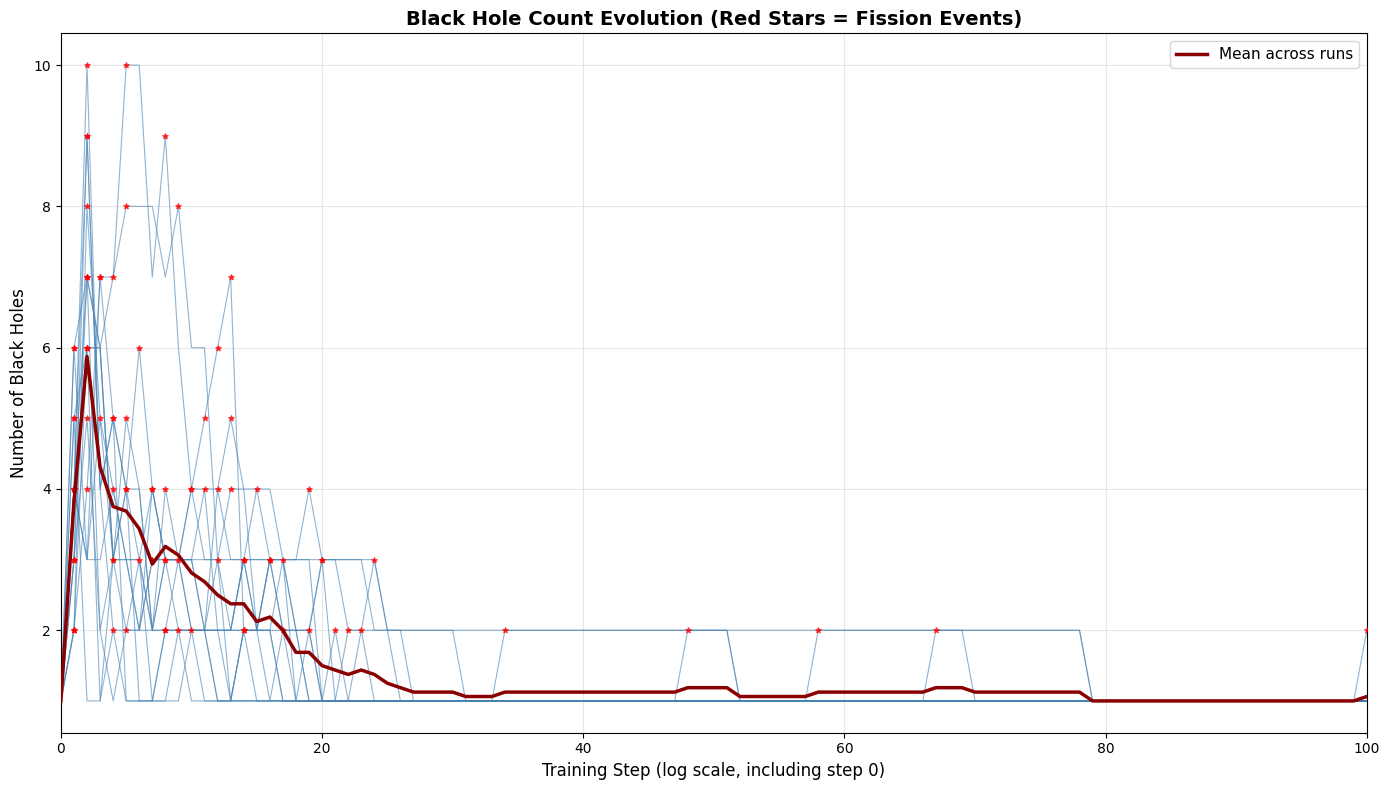


Mean count at step 0: 1.00 black holes
Mean count at step 1: 3.81 black holes
Mean count at step 100: 1.06 black holes
Mean count at step 1000: 1.00 black holes
Mean count at step 10000: 1.00 black holes


In [26]:
fig, ax = plt.subplots(figsize=(14, 8), dpi=DPI)

# Plot all runs with fission events marked
for run_name in sorted(counts_data.keys()):
    counts = counts_data[run_name]
    ax.plot(counts, linewidth=0.8, alpha=0.6, color='steelblue')
    
    # Mark fission events
    if run_name in fission_events and len(fission_events[run_name]) > 0:
        fission_steps = [step for step, _, _ in fission_events[run_name]]
        fission_counts = [counts[step] for step in fission_steps]
        ax.scatter(fission_steps, fission_counts, 
                  color='red', s=15, alpha=0.7, marker='*', zorder=5)

# Mean trajectory
all_counts = np.stack([counts_data[run] for run in sorted(counts_data.keys())])
mean_counts = np.mean(all_counts, axis=0)
ax.plot(mean_counts, linewidth=2.5, color='darkred', label='Mean across runs', zorder=10)

# ax.set_xscale('symlog', linthresh=1)
ax.set_xlim(0, 1e2)
ax.set_xscale('linear')
ax.set_xlabel('Training Step (log scale, including step 0)', fontsize=12)
ax.set_ylabel('Number of Black Holes', fontsize=12)
ax.set_title('Black Hole Count Evolution (Red Stars = Fission Events)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"\nMean count at step 0: {mean_counts[0]:.2f} black holes")
print(f"Mean count at step 1: {mean_counts[1]:.2f} black holes")
print(f"Mean count at step 100: {mean_counts[100]:.2f} black holes")
print(f"Mean count at step 1000: {mean_counts[1000]:.2f} black holes")
print(f"Mean count at step 10000: {mean_counts[10000]:.2f} black holes")

## Plot 4: Correlation Between Mean Size and Fission

Does mean black hole size drop when fission occurs?

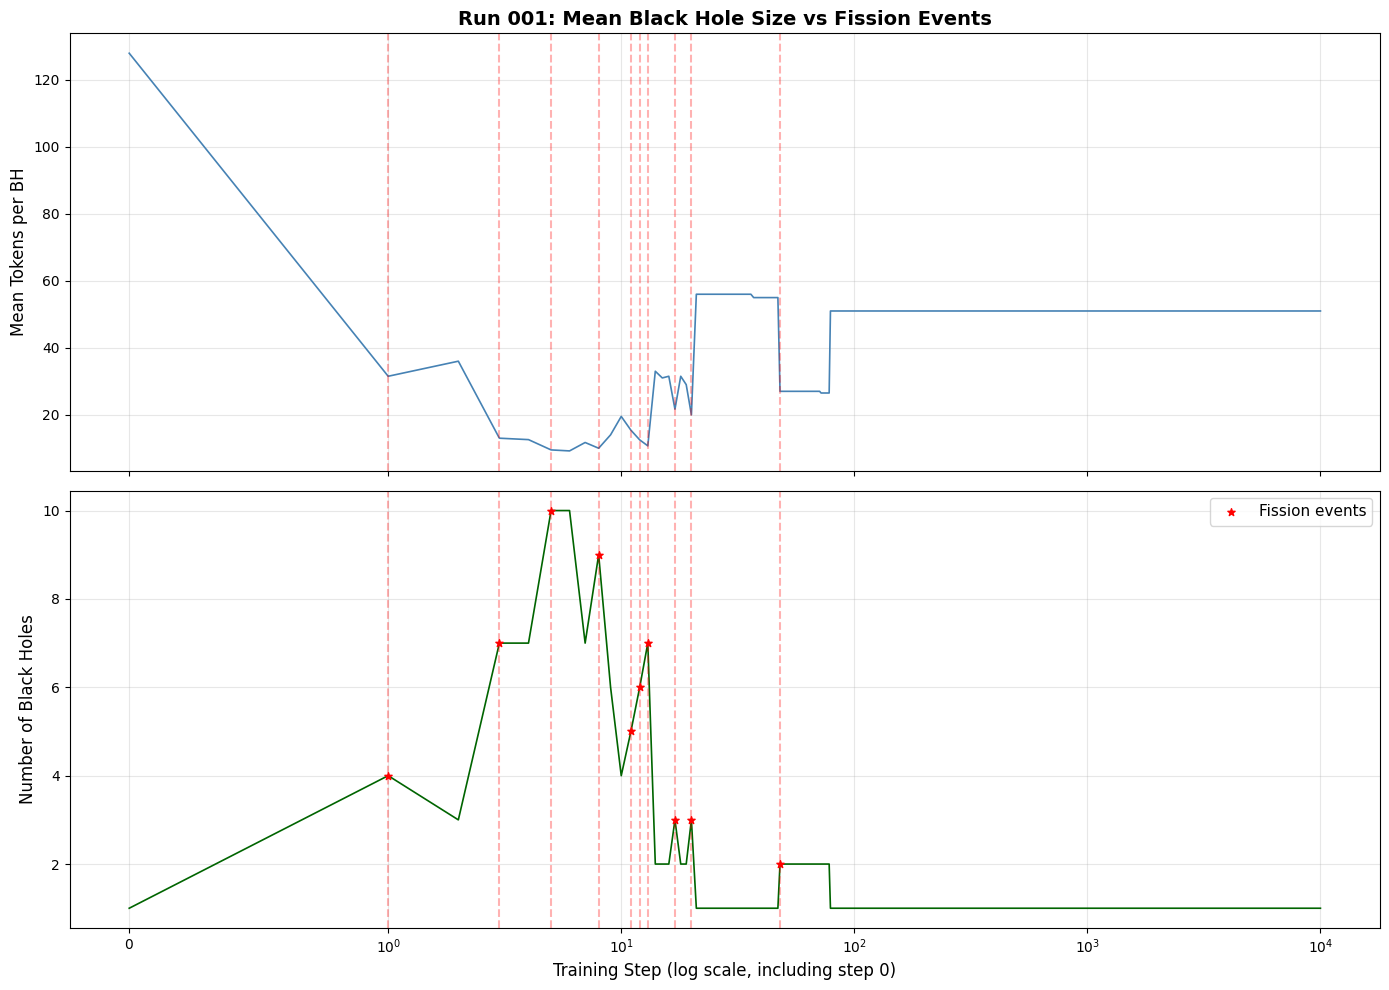

In [22]:
# Pick one representative run to examine in detail
example_run = '001'  # Run names are extracted as '001', '002', etc.

if example_run in mean_size_data:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), dpi=DPI, sharex=True)
    
    mean_size = mean_size_data[example_run]
    counts = counts_data[example_run]
    
    # Top panel: mean size
    steps = np.arange(len(mean_size))
    valid_mask = mean_size > 0
    ax1.plot(steps[valid_mask], mean_size[valid_mask], linewidth=1.2, color='steelblue')
    
    # Mark fission events
    if example_run in fission_events and len(fission_events[example_run]) > 0:
        fission_steps = [step for step, _, _ in fission_events[example_run]]
        for step in fission_steps:
            ax1.axvline(step, color='red', alpha=0.3, linewidth=1.5, linestyle='--')
    
    ax1.set_ylabel('Mean Tokens per BH', fontsize=12)
    ax1.set_title(f'Run {example_run}: Mean Black Hole Size vs Fission Events', 
                  fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xscale('symlog', linthresh=1)
    
    # Bottom panel: black hole count
    ax2.plot(counts, linewidth=1.2, color='darkgreen')
    
    # Mark fission events
    if example_run in fission_events and len(fission_events[example_run]) > 0:
        for step in fission_steps:
            ax2.axvline(step, color='red', alpha=0.3, linewidth=1.5, linestyle='--')
        
        # Scatter on top
        fission_counts = [counts[step] for step in fission_steps]
        ax2.scatter(fission_steps, fission_counts, 
                   color='red', s=30, marker='*', zorder=5, label='Fission events')
    
    ax2.set_xlabel('Training Step (log scale, including step 0)', fontsize=12)
    ax2.set_ylabel('Number of Black Holes', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_xscale('symlog', linthresh=1)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"⚠ Example run {example_run} not found in data")

## Statistical Summary

In [23]:
print(f"{'='*80}")
print("STATISTICAL SUMMARY")
print(f"{'='*80}\n")

print(f"Runs analyzed: {len(counts_data)}")
print(f"Training steps per run: {len(mean_trajectory)}")
print(f"Total fission events detected: {total_fission_events}")

# Early stage (steps 1-100)
early_mean_sizes = [mean_size_data[run][1:101] for run in sorted(mean_size_data.keys())]
early_mean_sizes_flat = [s for arr in early_mean_sizes for s in arr if s > 0]
print(f"\nEarly stage (steps 1-100):")
print(f"  Mean BH size: {np.mean(early_mean_sizes_flat):.2f} ± {np.std(early_mean_sizes_flat):.2f} tokens")

# Mid stage (steps 100-1000)
mid_mean_sizes = [mean_size_data[run][100:1001] for run in sorted(mean_size_data.keys())]
mid_mean_sizes_flat = [s for arr in mid_mean_sizes for s in arr if s > 0]
print(f"\nMid stage (steps 100-1000):")
print(f"  Mean BH size: {np.mean(mid_mean_sizes_flat):.2f} ± {np.std(mid_mean_sizes_flat):.2f} tokens")

# Late stage (steps 1000-10000)
late_mean_sizes = [mean_size_data[run][1000:] for run in sorted(mean_size_data.keys())]
late_mean_sizes_flat = [s for arr in late_mean_sizes for s in arr if s > 0]
print(f"\nLate stage (steps 1000-10000):")
print(f"  Mean BH size: {np.mean(late_mean_sizes_flat):.2f} ± {np.std(late_mean_sizes_flat):.2f} tokens")

# Fission rate
total_vector_steps = len(counts_data) * EXPECTED_STEPS * 128
fission_rate = total_vector_steps / total_fission_events if total_fission_events > 0 else float('inf')
print(f"\nFission rate: 1 event per {fission_rate:,.0f} vector-steps")

print(f"\n{'='*80}")

STATISTICAL SUMMARY

Runs analyzed: 16
Training steps per run: 10001
Total fission events detected: 95

Early stage (steps 1-100):
  Mean BH size: 45.90 ± 12.33 tokens

Mid stage (steps 100-1000):
  Mean BH size: 50.98 ± 0.74 tokens

Late stage (steps 1000-10000):
  Mean BH size: 51.00 ± 0.00 tokens

Fission rate: 1 event per 215,601 vector-steps

